In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
nbn = "04_" # Notebook Number; Prefix for artifacts path

In [14]:
datasets = ["DTD","EuroSAT","GTSRB","MNIST","SVHN","Caltech256","SUN397","iWildCam"]
nrow, ncol=3, 3
margin = 0.02

In [15]:
def eval_pred(pred):
    results = []
    for col in pred.columns.drop("target"):
        acc = (pred[col] == pred["target"]).mean()
        results.append({"Method": col, "Accuracy": acc})
    return pd.DataFrame(results)
def soft_vote(pred1, pred2):
    sum_pred = pred1+pred2
    return np.argmax(sum_pred,axis=1)
def cons_weighted_vote(pred1, pred2, weight1, weight2):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)
    return np.argmax(weighted_pred,axis=1)
def vec_weighted_vote(pred1, pred2, weightvec1, weightvec2):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0)
    return np.argmax(weighted_pred,axis=1)

def barplot_acc(pred, ds, ax):
    results_df = eval_pred(pred)
    
    sns.barplot(x='Method', y='Accuracy', data=results_df, ax=ax)
    
    pred101_acc = results_df.loc[results_df['Method'] == 'pred101', 'Accuracy'].values[0]
    pred18_acc = results_df.loc[results_df['Method'] == 'pred18', 'Accuracy'].values[0]
    
    baseline_acc = max(pred101_acc, pred18_acc)
    baseline_method = 'pred101' if baseline_acc == pred101_acc else 'pred18'
    
    ax.axhline(y=baseline_acc, color='r', linestyle='--')
    ax.text(len(results_df) - 1, baseline_acc, f"Baseline ({baseline_method}): {baseline_acc:.2%}", color='r', ha='center', va='bottom')
    
    for index, row in results_df.iterrows():
        ax.text(index, row['Accuracy'], f"{row['Accuracy']:.2%}", color='black', ha="center")
    
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(f'Ensemble Accuracy on {ds}')
    ax.set_xlabel('Ensembling Method')
    ax.set_ylabel('Accuracy')
    
    min_acc = results_df['Accuracy'].min()
    max_acc = results_df['Accuracy'].max()
    ax.set_ylim(min_acc - margin, min(1, max_acc + margin))

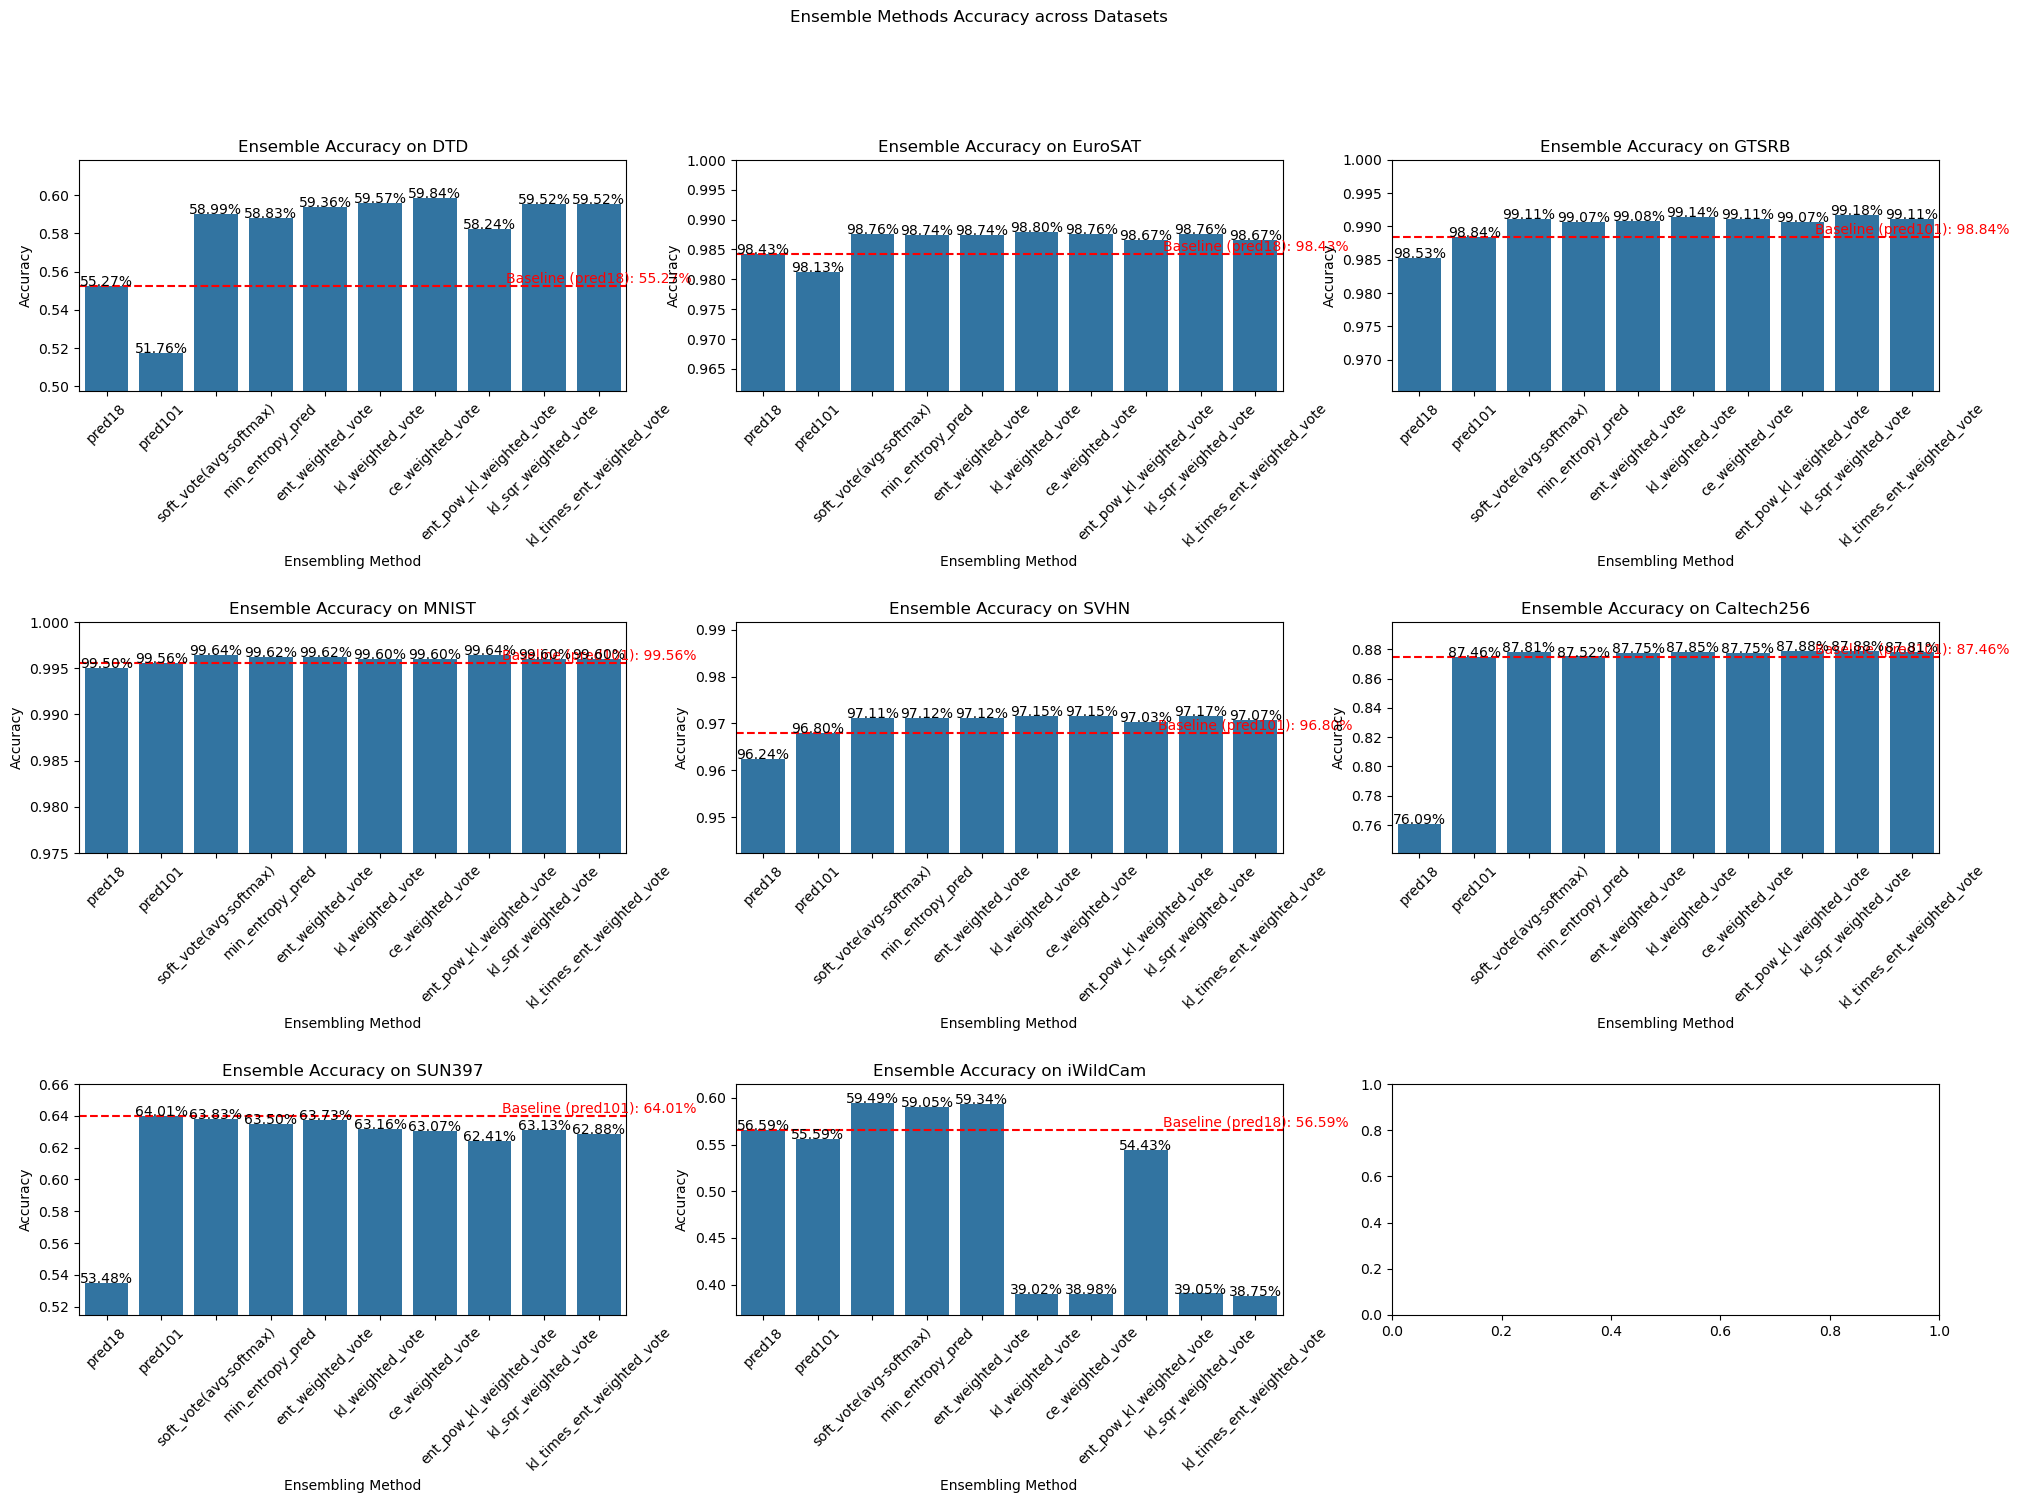

In [16]:
fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))

for i, ds in enumerate(datasets):
    df18 = pd.read_csv(f"../Pred/{ds}_Resnet18.csv")
    df101 = pd.read_csv(f"../Pred/{ds}_Resnet101.csv")
    label = pd.read_csv(f"../Pred/target_{ds}.csv")
    pred = pd.read_csv(f"prediction_{ds}.csv",index_col="Unnamed: 0").drop("pred50",axis=1)
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv")
    pred["soft_vote(avg-softmax)"] = soft_vote(df18, df101)
    pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_101"],pred["pred101"],pred["pred18"])
    pred["ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])
    pred["kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
    pred["ce_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ce_101_18"], unc_pred["ce_18_101"])
    pred["ent_pow_kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"]**unc_pred["kl_101_18"], unc_pred["ent_18"]**unc_pred["kl_18_101"])
    pred["kl_sqr_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**2, unc_pred["kl_18_101"]**2)
    pred["kl_times_ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]*unc_pred["ent_101"], unc_pred["kl_18_101"]*unc_pred["ent_18"])
    ax = axes[i // ncol, i % ncol]
    barplot_acc(pred,ds,ax)
plt.subplots_adjust(hspace=1)
plt.suptitle("Ensemble Methods Accuracy across Datasets")
plt.savefig(f"artifacts/{nbn}ensemble.png")
plt.show()

In [17]:
def soft_vote(pred1, pred2):
    sum_pred = pred1+pred2
    row_sums = sum_pred.sum(axis=1)
    normalized_pred = sum_pred.div(row_sums, axis=0)
    return normalized_pred
def cons_weighted_vote(pred1, pred2, weight1, weight2):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)
    row_sums = weighted_pred.sum(axis=1)
    normalized_pred = weighted_pred.div(row_sums, axis=0)
    return normalized_pred
def vec_weighted_vote(pred1, pred2, weightvec1, weightvec2):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0)
    row_sums = weighted_pred.sum(axis=1)
    normalized_pred = weighted_pred.div(row_sums, axis=0)
    return normalized_pred

In [18]:
def eval_pred_nll(pred_ls,ens_name_ls,label):
    results = []
    flat_label = label['target'].values.flatten()
    for i, curr_pred in enumerate(pred_ls):
        curr_array = curr_pred.values
        nll = np.sum(-np.log(curr_array[np.arange(curr_pred.shape[0]), flat_label]))
        results.append({"Method": ens_name_ls[i], "NLL": nll})
    return pd.DataFrame(results)

def barplot_nll(pred_ls,ens_name_ls, label, ds,ax):
    results_df = eval_pred_nll(pred_ls,ens_name_ls,label)
    # display(results_df)
    sns.barplot(x='Method', y='NLL', data=results_df, ax=ax)
    
    # pred101_acc = results_df.loc[results_df['Method'] == 'pred101', 'NLL'].values[0]
    # pred18_acc = results_df.loc[results_df['Method'] == 'pred18', 'NLL'].values[0]
    
    # baseline_acc = min(pred101_acc, pred18_acc)
    # baseline_method = 'pred101' if baseline_acc == pred101_acc else 'pred18'
    
    # ax.axhline(y=baseline_acc, color='r', linestyle='--')
    # ax.text(len(results_df) - 1, baseline_acc, f"Baseline ({baseline_method}): {baseline_acc:.2%}", color='r', ha='center', va='bottom')
    
    for index, row in results_df.iterrows():
        ax.text(index, row['NLL'], f"{row['NLL']:.2f}", color='black', ha="center")
    
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(f'Ensemble NLL on {ds} (lower is better)')
    ax.set_xlabel('Ensembling Method')
    ax.set_ylabel('NLL')
    
    # min_acc = results_df['NLL'].min()
    # max_acc = results_df['NLL'].max()
    # ax.set_ylim(min_acc - margin, min(1, max_acc + margin))

,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_37,class_38,class_39,class_40,class_41,class_42,class_43,class_44,class_45,class_46
0,0.99434,5.005885e-08,0.000013,1.656837e-07,1.247636e-08,0.000003,3.779715e-08,0.000021,0.000213,5.199001e-09,...,7.753800e-08,1.483747e-07,0.000089,9.625238e-08,0.000008,5.525660e-08,0.000001,1.699211e-07,0.000002,0.000097


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_37,class_38,class_39,class_40,class_41,class_42,class_43,class_44,class_45,class_46
0,0.999908,2.581255e-08,1.936404e-07,2.461707e-09,7.679571e-09,1.100049e-07,1.929761e-09,2.201164e-07,0.000002,2.948566e-09,...,2.448830e-09,5.763673e-09,0.000001,1.745068e-09,1.425912e-07,6.757385e-08,1.536100e-08,2.690443e-09,2.660449e-08,0.000001


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_37,class_38,class_39,class_40,class_41,class_42,class_43,class_44,class_45,class_46
0,0.99414,5.093142e-08,0.000014,1.715576e-07,1.264898e-08,0.000003,3.908793e-08,0.000021,0.00022,5.279989e-09,...,8.024028e-08,1.535069e-07,0.000092,9.965346e-08,0.000008,5.481333e-08,0.000001,1.759393e-07,0.000002,0.000101


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_37,class_38,class_39,class_40,class_41,class_42,class_43,class_44,class_45,class_46
0,0.999591,2.719211e-08,9.496114e-07,1.174865e-08,7.952497e-09,2.871640e-07,3.970531e-09,0.000001,0.000014,3.076610e-09,...,6.721228e-09,1.387791e-08,0.000006,7.122312e-09,5.918048e-07,6.687303e-08,7.245349e-08,1.220547e-08,1.335370e-07,0.000007


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,7.490383e-13,3.053021e-14,2.414409e-11,3.338543e-10,1.292452e-11,4.714985e-11,1.0,5.809115e-13,2.180889e-12,5.266243e-17


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,2.196368e-13,8.170779e-15,4.080464e-11,1.285692e-10,3.727526e-12,1.263151e-11,1.0,2.103458e-13,6.662353e-13,1.390722e-17


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,7.490383e-13,3.053021e-14,2.414409e-11,3.338543e-10,1.292452e-11,4.714985e-11,1.0,5.809115e-13,2.180889e-12,5.266243e-17


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,2.985582e-14,1.553220e-16,4.677715e-11,5.497812e-11,4.305683e-13,2.573067e-13,1.0,7.750466e-14,1.232589e-13,1.416882e-20


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_33,class_34,class_35,class_36,class_37,class_38,class_39,class_40,class_41,class_42
0,7.075140e-15,1.040701e-11,1.0,2.767289e-09,2.834016e-12,2.471579e-10,2.039744e-15,2.443691e-13,1.615239e-12,2.005459e-13,...,2.464378e-08,9.132734e-15,3.947003e-17,1.519845e-14,3.199399e-15,2.516942e-12,1.428741e-14,9.427533e-14,1.218439e-13,1.118683e-15


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_33,class_34,class_35,class_36,class_37,class_38,class_39,class_40,class_41,class_42
0,3.744232e-19,5.507654e-16,1.0,1.003856e-12,1.499893e-16,5.179544e-14,1.080820e-19,9.177935e-17,8.555880e-17,1.061437e-17,...,1.304192e-12,1.844447e-18,2.089150e-21,8.043174e-19,1.736509e-19,1.346813e-16,7.561095e-19,1.869317e-17,6.461441e-18,7.123105e-20


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_33,class_34,class_35,class_36,class_37,class_38,class_39,class_40,class_41,class_42
0,7.075195e-15,1.040709e-11,1.0,2.767311e-09,2.834038e-12,2.471598e-10,2.039760e-15,2.443710e-13,1.615251e-12,2.005474e-13,...,2.464398e-08,9.132805e-15,3.947034e-17,1.519857e-14,3.199424e-15,2.516961e-12,1.428752e-14,9.427607e-14,1.218448e-13,1.118692e-15


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_33,class_34,class_35,class_36,class_37,class_38,class_39,class_40,class_41,class_42
0,8.247050e-25,1.756330e-20,1.0,8.574541e-13,1.077184e-20,3.871768e-14,1.369701e-22,7.885130e-17,7.900816e-20,1.308541e-21,...,2.241404e-17,1.361207e-18,3.625821e-25,2.308945e-24,4.336210e-21,1.482681e-18,7.763313e-24,1.370476e-17,1.335966e-20,1.203003e-20


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,7.925905e-22,3.038271e-25,3.827795e-18,1.796474e-22,1.178831e-21,5.118578e-16,1.0,3.218674e-25,1.864550e-18,5.782515e-20


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,1.382673e-21,4.062310e-29,2.334805e-21,2.358255e-26,2.093433e-23,1.152804e-19,1.0,4.225078e-29,1.377418e-21,9.123306e-24


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,7.925905e-22,3.038271e-25,3.827795e-18,1.796474e-22,1.178831e-21,5.118578e-16,1.0,3.218674e-25,1.864550e-18,5.782515e-20


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,1.382750e-21,7.420015e-31,1.832599e-21,1.529609e-30,2.078233e-23,4.809885e-20,1.0,1.570863e-33,1.132821e-21,1.533215e-24


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,7.501238e-20,4.731122e-16,1.0,1.483954e-12,4.398157e-17,9.509159e-13,3.310818e-17,3.795692e-12,7.559424e-16,2.920828e-19


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,5.320336e-20,1.496603e-16,1.0,4.697359e-13,6.442774e-17,1.599448e-12,1.054536e-17,1.200367e-12,9.379926e-16,4.445352e-19


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,7.501238e-20,4.731122e-16,1.0,1.483954e-12,4.398157e-17,9.509159e-13,3.310818e-17,3.795692e-12,7.559424e-16,2.920828e-19


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,4.368713e-20,8.524043e-18,1.0,2.718792e-14,7.334930e-17,1.882431e-12,7.002102e-19,6.791262e-14,1.017429e-15,5.110568e-19


/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_36774/1205475185.py:6: RuntimeWarning: invalid value encountered in log
  nll = np.sum(-np.log(curr_array[np.arange(curr_pred.shape[0]), flat_label]))


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
0,0.000008,0.000013,0.000019,0.000013,0.000024,0.000009,0.000012,0.995111,0.000048,0.000017,...,0.000007,0.000009,0.000015,0.000013,0.000016,0.000021,0.000011,0.000014,0.00003,0.000011


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
0,0.000009,0.000013,0.000019,0.000012,0.000025,0.00001,0.000012,0.995407,0.000039,0.000015,...,0.000008,0.000008,0.000013,0.000013,0.000015,0.000021,0.00001,0.000014,0.00003,0.000011


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
0,0.000008,0.000013,0.000019,0.000013,0.000024,0.000009,0.000012,0.995108,0.000048,0.000017,...,0.000007,0.000009,0.000015,0.000013,0.000016,0.000021,0.000011,0.000014,0.00003,0.000011


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
0,0.00001,0.000013,0.000018,0.000011,0.000026,0.000011,0.000012,0.995759,0.000028,0.000013,...,0.00001,0.000007,0.000009,0.000012,0.000014,0.00002,0.00001,0.000015,0.00003,0.000012


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_387,class_388,class_389,class_390,class_391,class_392,class_393,class_394,class_395,class_396
0,2.799583e-12,1.342437e-14,3.638563e-15,1.706915e-12,2.406499e-10,1.860739e-18,3.291164e-11,5.431531e-14,7.667984e-18,2.173354e-14,...,2.012837e-18,4.952323e-13,1.051917e-10,1.577805e-11,8.363659e-14,3.265943e-12,5.628864e-13,1.332343e-17,2.704020e-10,2.322751e-08


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_387,class_388,class_389,class_390,class_391,class_392,class_393,class_394,class_395,class_396
0,5.597639e-12,3.565181e-17,7.248895e-15,3.408351e-12,3.889081e-10,4.221865e-20,6.580768e-11,4.111814e-14,1.270258e-17,4.345362e-14,...,4.024709e-18,3.562522e-16,5.357086e-11,3.154851e-11,1.667770e-13,6.530338e-12,2.476162e-13,2.267805e-20,1.149850e-11,3.467145e-10


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_387,class_388,class_389,class_390,class_391,class_392,class_393,class_394,class_395,class_396
0,2.562743e-12,1.455765e-14,3.332968e-15,1.562898e-12,2.281006e-10,2.014667e-18,3.012717e-11,5.543237e-14,7.241834e-18,1.989506e-14,...,1.842543e-18,5.371208e-13,1.095611e-10,1.444317e-11,7.659921e-14,2.989630e-12,5.895723e-13,1.444926e-17,2.923168e-10,2.516425e-08


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_387,class_388,class_389,class_390,class_391,class_392,class_393,class_394,class_395,class_396
0,5.526011e-12,3.783941e-16,7.156473e-15,3.364795e-12,3.851128e-10,8.877158e-20,6.496557e-11,4.145598e-14,1.257370e-17,4.289760e-14,...,3.973207e-18,1.302475e-14,5.489231e-11,3.114479e-11,1.646487e-13,6.446772e-12,2.556869e-13,3.631685e-19,1.812626e-11,9.324480e-10


/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_36774/1205475185.py:6: RuntimeWarning: invalid value encountered in log
  nll = np.sum(-np.log(curr_array[np.arange(curr_pred.shape[0]), flat_label]))


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_172,class_173,class_174,class_175,class_176,class_177,class_178,class_179,class_180,class_181
0,0.996651,1.449216e-09,2.964126e-07,3.094040e-09,2.333554e-10,2.584878e-11,2.812714e-09,6.699635e-08,1.288060e-09,7.391387e-10,...,1.745106e-10,6.032421e-13,1.760645e-09,4.258282e-12,1.899505e-11,1.647651e-11,1.188082e-08,1.339467e-12,8.880779e-13,3.043421e-11


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_172,class_173,class_174,class_175,class_176,class_177,class_178,class_179,class_180,class_181
0,0.997332,1.036778e-09,4.353451e-07,1.687477e-09,2.424619e-10,3.502767e-11,3.775403e-09,4.007789e-08,1.741289e-09,4.001697e-10,...,1.030962e-10,3.915232e-13,2.516969e-09,2.263166e-12,1.009601e-11,1.012576e-11,1.470505e-08,7.094752e-13,4.702743e-13,4.342727e-11


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_172,class_173,class_174,class_175,class_176,class_177,class_178,class_179,class_180,class_181
0,0.996577,1.493453e-09,2.815110e-07,3.244904e-09,2.323786e-10,2.486427e-11,2.709458e-09,6.988356e-08,1.239448e-09,7.754957e-10,...,1.821703e-10,6.259506e-13,1.679524e-09,4.472274e-12,1.994955e-11,1.715768e-11,1.157790e-08,1.407039e-12,9.328906e-13,2.904061e-11


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_172,class_173,class_174,class_175,class_176,class_177,class_178,class_179,class_180,class_181
0,0.998064,5.932994e-10,5.847336e-07,1.750560e-10,2.522538e-10,4.489737e-11,4.810544e-09,1.113356e-08,2.228628e-09,3.569001e-11,...,2.630716e-11,1.638703e-13,3.330213e-09,1.178970e-13,5.272189e-13,3.297057e-12,1.774184e-08,3.207021e-14,2.102687e-14,5.739818e-11


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

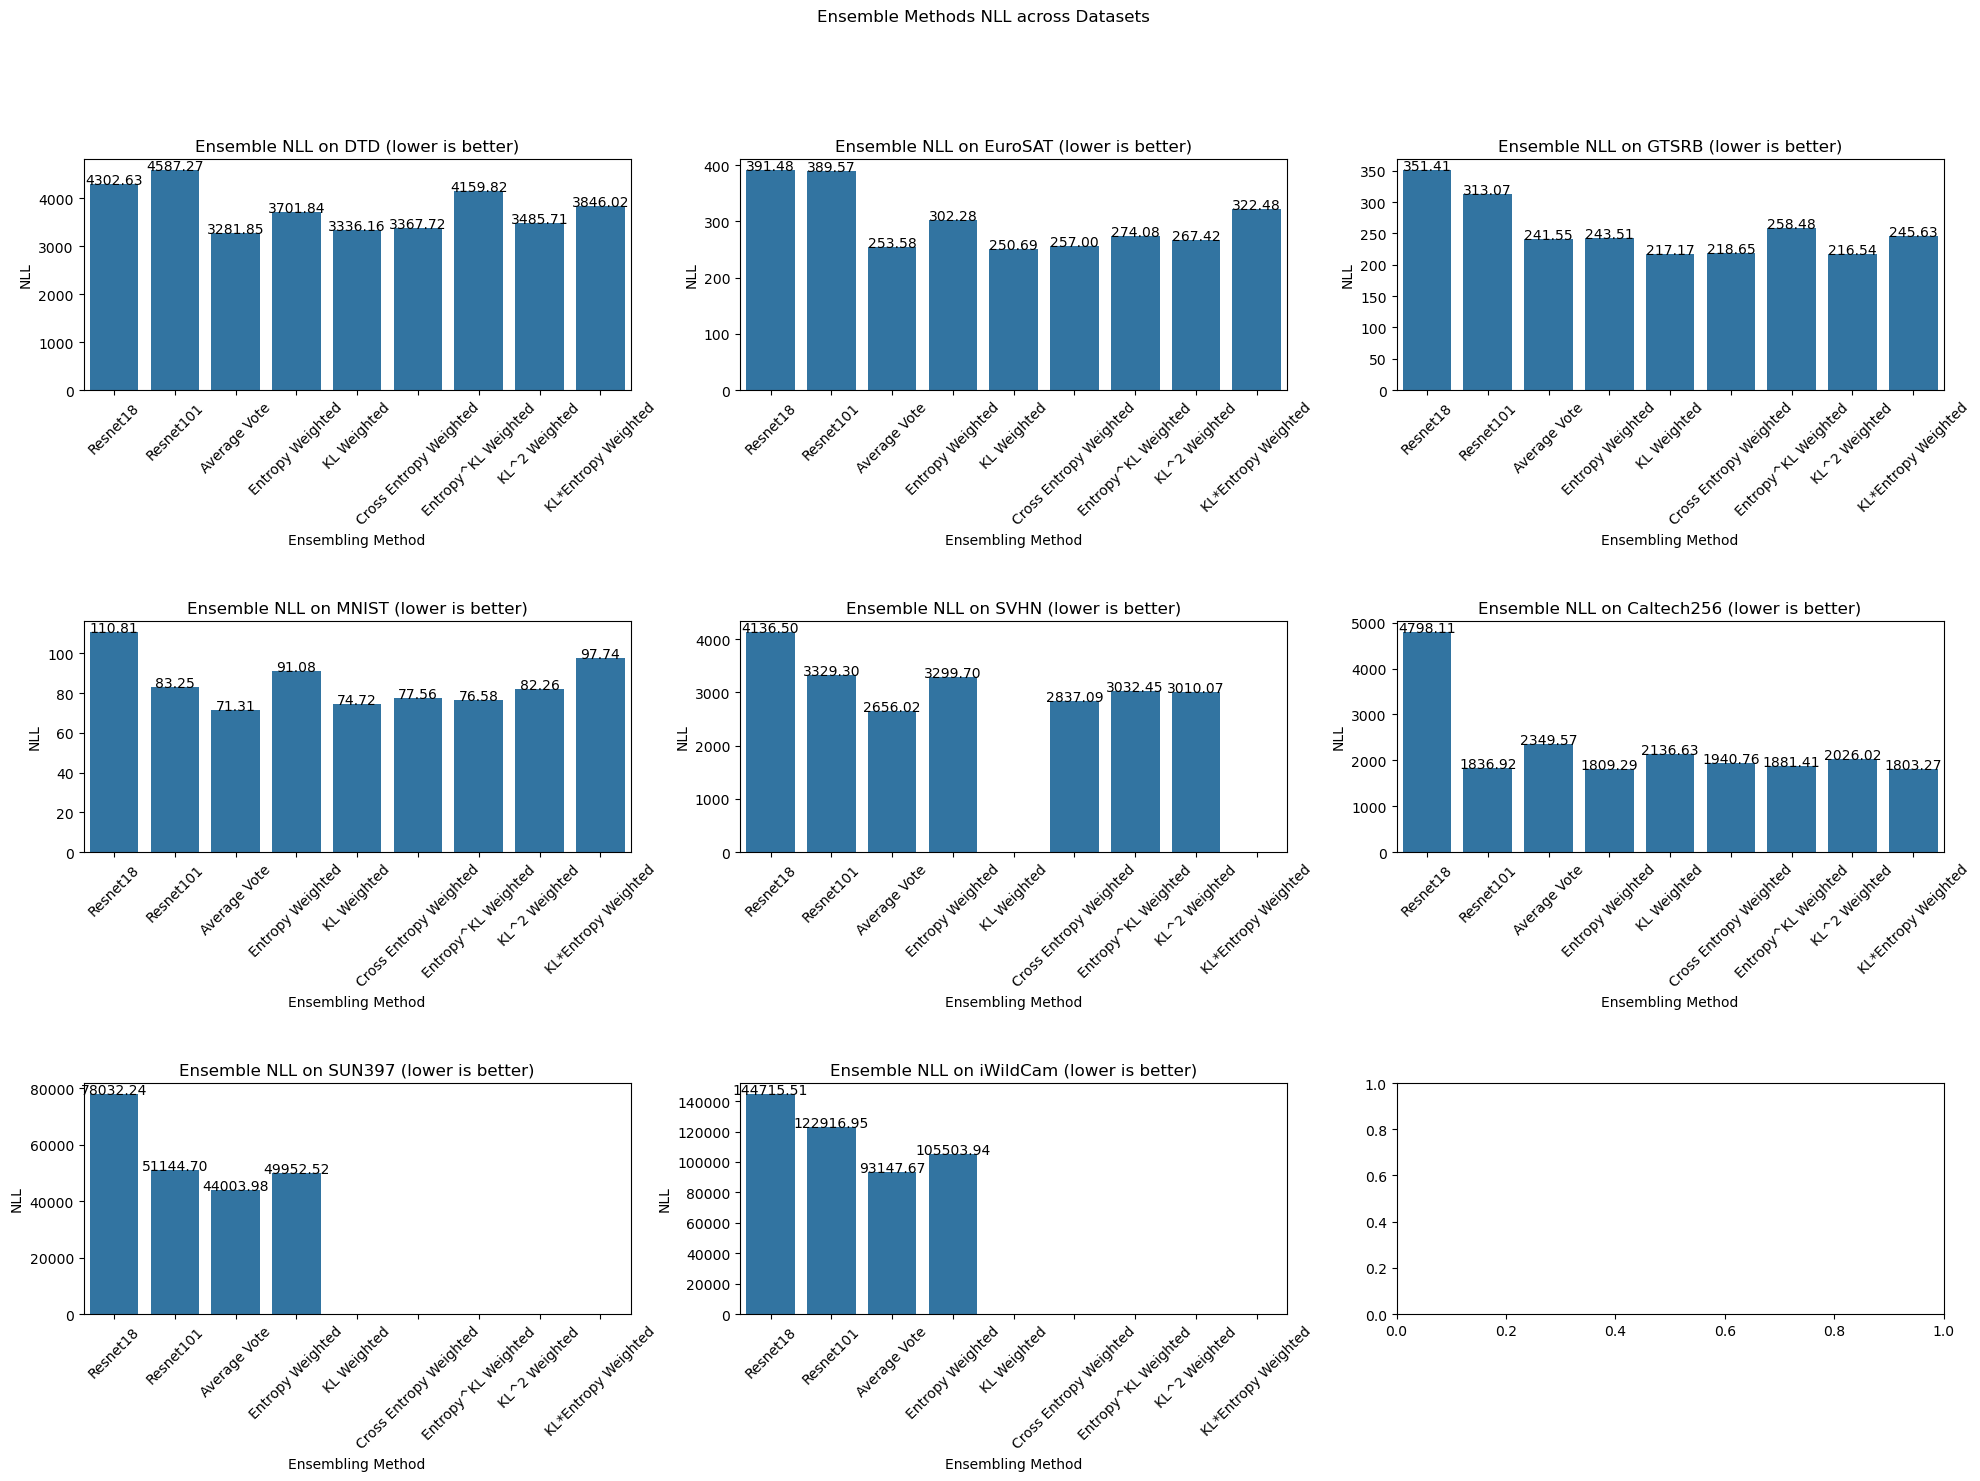

In [19]:
fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))

for i, ds in enumerate(datasets):
    df18 = pd.read_csv(f"../Pred/{ds}_Resnet18.csv")
    df101 = pd.read_csv(f"../Pred/{ds}_Resnet101.csv")
    label = pd.read_csv(f"../Pred/target_{ds}.csv")
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv")
    df_soft_vote = soft_vote(df18, df101)
    df_entr_w = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])
    df_kl_w = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
    df_ce_w = vec_weighted_vote(df18, df101, unc_pred["ce_101_18"], unc_pred["ce_18_101"])
    df_entr_pow_kl_w = vec_weighted_vote(df18, df101, unc_pred["ent_101"]**unc_pred["kl_101_18"], unc_pred["ent_18"]**unc_pred["kl_18_101"])
    df_kl_sqr_w = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**2, unc_pred["kl_18_101"]**2)
    df_kl_t_entr_w = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]*unc_pred["ent_101"], unc_pred["kl_18_101"]*unc_pred["ent_18"])
    display(df_soft_vote.head(1))
    display(df_entr_w.head(1))
    display(df_entr_pow_kl_w.head(1))
    display(df_kl_sqr_w.head(1))
    ax = axes[i // ncol, i % ncol]
    pred_ls = [df18,df101,df_soft_vote, df_entr_w, df_kl_w, df_ce_w, df_entr_pow_kl_w, df_kl_sqr_w, df_kl_t_entr_w]
    ens_name_ls = ["Resnet18","Resnet101","Average Vote", "Entropy Weighted", "KL Weighted", "Cross Entropy Weighted", "Entropy^KL Weighted", "KL^2 Weighted", "KL*Entropy Weighted"]
    barplot_nll(pred_ls,ens_name_ls,label,ds,ax)
plt.subplots_adjust(hspace=1)
plt.suptitle("Ensemble Methods NLL across Datasets")
plt.savefig(f"artifacts/{nbn}ensemble_nll.png")
plt.show()

It's surprising that simply averaging predictions from a smaller model and a larger model is consistantly improving on accuracy, investigate: what kind of data is ensemble more likely to get right?
For this part let's focus on soft_vote since that's the simplest one

In [20]:
datasets = ["DTD","EuroSAT","GTSRB","MNIST","SVHN","Caltech256"]
datasets = ["EuroSAT"]

In [21]:
def load_data(ds):
    df18 = pd.read_csv(f"../Pred/{ds}_Resnet18.csv")
    df101 = pd.read_csv(f"../Pred/{ds}_Resnet101.csv")
    label = pd.read_csv(f"../Pred/target_{ds}.csv")
    pred = pd.read_csv(f"prediction_{ds}.csv", index_col="Unnamed: 0").drop("pred50", axis=1)
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv")
    pred["soft_vote(avg-softmax)"] = soft_vote(df18, df101)
    pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_101"],pred["pred101"],pred["pred18"])
    pred["ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])
    pred["kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
    pred["ce_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ce_101_18"], unc_pred["ce_18_101"])
    pred["ent_pow_kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"]**unc_pred["kl_101_18"], unc_pred["ent_18"]**unc_pred["kl_18_101"])
    pred["kl_sqr_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**2, unc_pred["kl_18_101"]**2)
    pred["kl_times_ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]*unc_pred["ent_101"], unc_pred["kl_18_101"]*unc_pred["ent_18"])
    return df18, df101, label, pred, unc_pred

In [22]:
def plot_kde(ax, data, title, label_suffix=''):
    sns.kdeplot(data=data, x="ent_18", label=f"entropy 18 {label_suffix}", ax=ax)
    sns.kdeplot(data=data, x="ent_101", label=f"entropy 101 {label_suffix}", ax=ax)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Density')

In [23]:
def plot_predictions(pred, unc_pred, axes_row, ens_method):
    conditions = [
        (pred["pred18"] == pred["target"]) & (pred["pred101"] == pred["target"]) & (pred[ens_method] == pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] == pred["target"]) & (pred[ens_method] == pred["target"]),
        (pred["pred18"] == pred["target"]) & (pred["pred101"] != pred["target"]) & (pred[ens_method] == pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] != pred["target"]) & (pred[ens_method] == pred["target"]),
        (pred["pred18"] == pred["target"]) & (pred["pred101"] == pred["target"]) & (pred[ens_method] != pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] == pred["target"]) & (pred[ens_method] != pred["target"]),
        (pred["pred18"] == pred["target"]) & (pred["pred101"] != pred["target"]) & (pred[ens_method] != pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] != pred["target"]) & (pred[ens_method] != pred["target"])
    ]
    
    titles = [
        '18 Cor & 101 Cor: #{}',
        '18 Incor & 101 Cor: #{}',
        '18 Cor & 101 Incor: #{}',
        '18 Incor & 101 Incor: #{}'
    ]
    
    for i, ax in enumerate(axes_row[:4]):
        condition = conditions[i]
        filtered_unc_pred = unc_pred[condition]
        temp_title = titles[i].format(filtered_unc_pred.shape[0])
        plot_kde(ax, filtered_unc_pred, temp_title, label_suffix='; Correct Soft Vote')
        condition = conditions[i + 4]
        filtered_unc_pred = unc_pred[condition]
        plot_kde(ax, filtered_unc_pred, temp_title+"||"+str(filtered_unc_pred.shape[0]), label_suffix='; Incorrect Soft Vote')


ValueError: Cannot set a DataFrame with multiple columns to the single column soft_vote(avg-softmax)

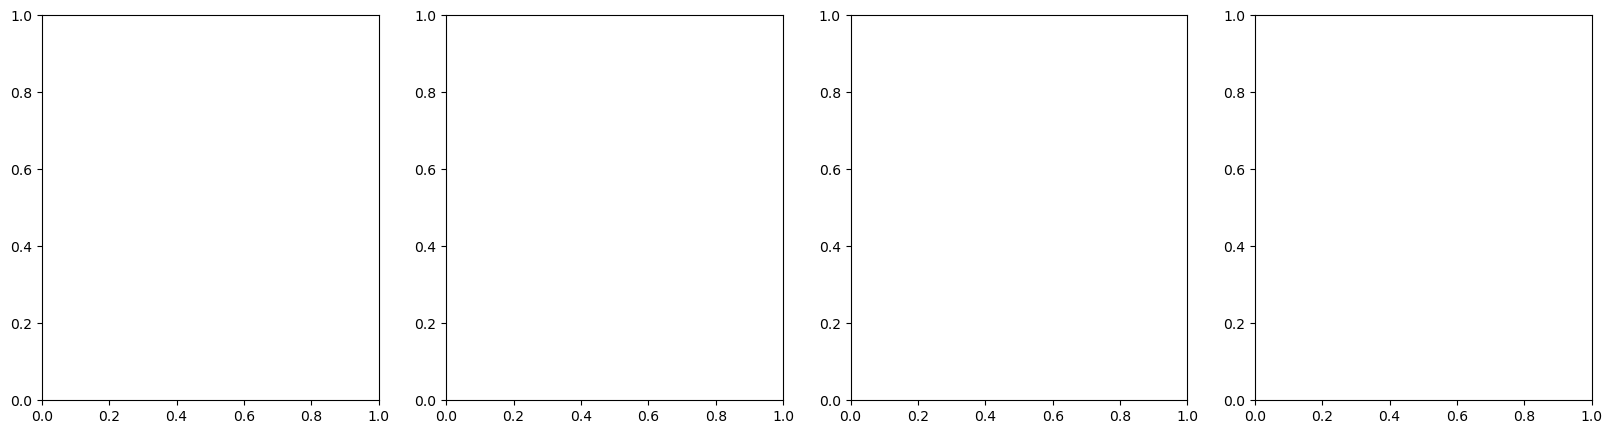

In [24]:
fig, axes = plt.subplots(len(datasets), 4, figsize=(20, 5 * len(datasets)))

# If there's only one dataset, axes will not be a 2D array, so handle that case
if len(datasets) == 1:
    axes = [axes]

for i, ds in enumerate(datasets):
    df18, df101, label, pred, unc_pred = load_data(ds)
    plot_predictions(pred, unc_pred, axes[i], "soft_vote(avg-softmax)")
    for ax in axes[i]:
        ax.text(0.5, 1.05, ds, transform=ax.transAxes, ha='center', va='bottom', fontsize='large')

plt.tight_layout()
plt.savefig(f"artifacts/{nbn}entropy_conditioned_on_ensemble.png")
# plt.show()

/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_73177/992642571.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x="ent_18", label=f"entropy 18 {label_suffix}", ax=ax)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_73177/992642571.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x="ent_101", label=f"entropy 101 {label_suffix}", ax=ax)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_73177/992642571.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x="ent_18", label=f"entropy 18 {label_suffix}", ax=ax)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_73177/992642571.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=Fa

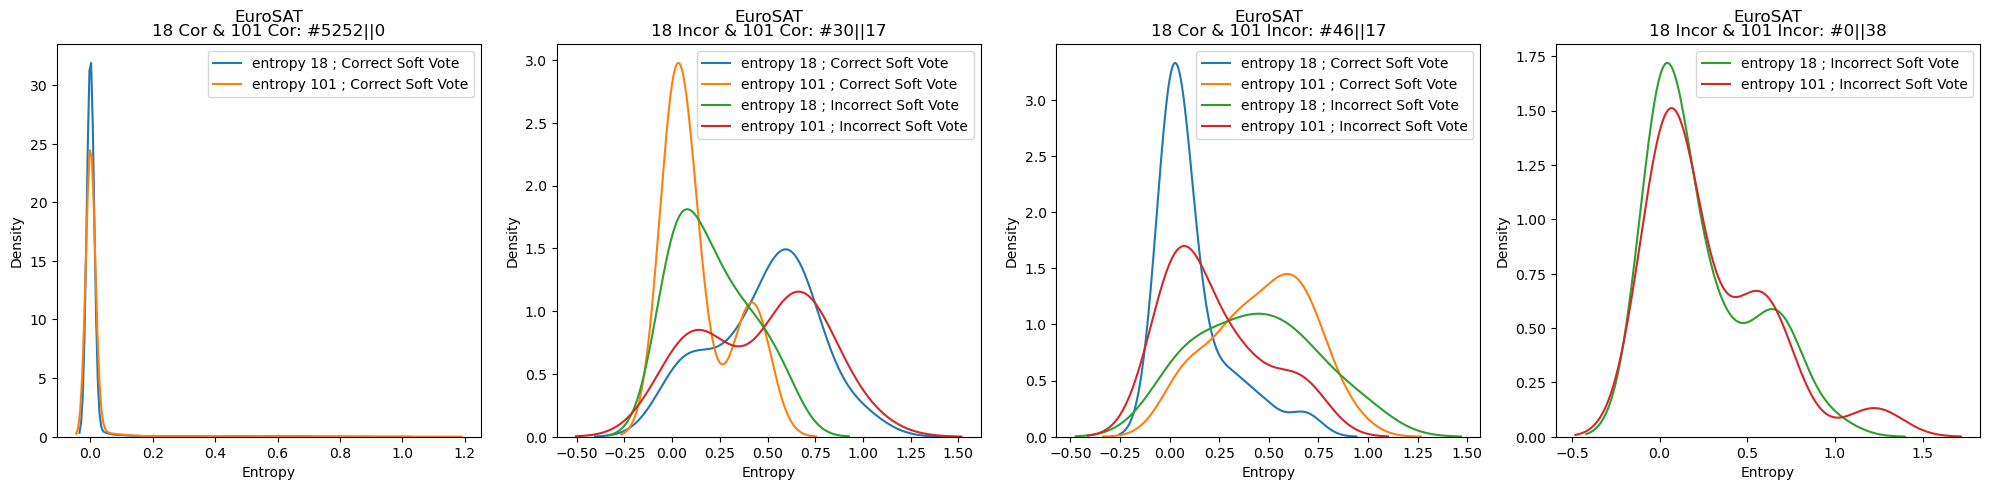

In [ ]:
fig, axes = plt.subplots(len(datasets), 4, figsize=(20, 5 * len(datasets)))

# If there's only one dataset, axes will not be a 2D array, so handle that case
if len(datasets) == 1:
    axes = [axes]

for i, ds in enumerate(datasets):
    df18, df101, label, pred, unc_pred = load_data(ds)
    plot_predictions(pred, unc_pred, axes[i], "ent_pow_kl_weighted_vote")
    for ax in axes[i]:
        ax.text(0.5, 1.05, ds, transform=ax.transAxes, ha='center', va='bottom', fontsize='large')

plt.tight_layout()
# plt.savefig(f"artifacts/{nbn}entropy_conditioned_on_ensemble.png")
plt.show()